In [223]:
from data_pipeline.np_dataset import NpDataset
import input_mapping.models_torch as models_torch
from data_pipeline.image_transforms import get_transforms

from data_pipeline.data_package import DataPackage





from PIL import Image
from pydicom import dcmread
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import numpy as np

from ai_backend.loggers.model_logger import is_min
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam
import torch
import json
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recall
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd



In [224]:
#checkpoint 1
augmentations = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(p=0.6),
                transforms.RandomVerticalFlip(p=0.5)
            ])

In [225]:
#create np datasets for training, validation and testing
read_dicom = lambda x: dcmread(x).pixel_array
dicom_file_reader = lambda x: Image.fromarray(read_dicom(x)).convert('RGB')
default_file_reader = lambda x: Image.open(x).convert('RGB')


In [226]:
model_id = '05aac62e-b966-49cc-a2e8-0d4a03a8dc53'
model_key = 'resnet18'
model_folder = f'models/{model_key}/{model_id}'
path_to_model_conig = f'{model_folder}/run_config.json'
#load the model configuration
with open(path_to_model_conig, 'r') as f:
    run_config = json.load(f)
#also

In [227]:
transform_type = run_config['transform_type']
transforms_config = models_torch.model_dict[model_key]['transforms_config']
transform = get_transforms(transform_name = transform_type, transforms_config = transforms_config)

In [228]:
#train the model
dataset_name = '2024-06-05_16-22-01'
#load the dataset configuration
path_to_dataset_config = f'datasets/{dataset_name}/dataset_config.json'

with open(path_to_dataset_config, 'r') as f:
    dataset_config = json.load(f)
#get the the labels
labels_to_encode = dataset_config['labels_to_encode']


In [229]:
best_model_save_folder = f'models/{model_key}/{model_id}'
best_model_save_path = f'{best_model_save_folder}/weights.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [230]:
def convert_package_to_dataset(package, augmentations=None):
    file_reader = dicom_file_reader if package.data_source_name == 'UKB' else default_file_reader
    dataset = NpDataset(file_paths=package.get_data(), labels=package.get_labels(),
                         file_reader=file_reader, transform=transform, augmentation_transform=augmentations)
    return dataset

def convert_package_list_to_dataset(package_list, augmentations=None):
    datasets = []
    for package in package_list:
        dataset = convert_package_to_dataset(package)
        datasets.append(dataset)
    return datasets

In [231]:
#list the saved directories and load the datapackages
dataset_path = 'datasets/2024-06-05_16-22-01'
train_packages_path = f'{dataset_path}/train'
val_packages_path = f'{dataset_path}/val'
test_packages_path = f'{dataset_path}/test'
package_paths = [train_packages_path, val_packages_path, test_packages_path]
train_packages = []
val_packages = []
test_packages = []
all_packages = [train_packages, val_packages, test_packages]

for path, package_list  in zip(package_paths, all_packages):
    files = os.listdir(path)
    for file in files:
        package = DataPackage.load(f'{path}/{file}')
        package_list.append(package)
#convert to np datasets
train_datasets = convert_package_list_to_dataset(train_packages, augmentations=augmentations)
val_datasets = convert_package_list_to_dataset(val_packages)
test_datasets = convert_package_list_to_dataset(test_packages)


In [249]:
#concat the datasets
train_dataset = ConcatDataset(train_datasets)
validation_dataset = ConcatDataset(val_datasets)
test_dataset = ConcatDataset(test_datasets)

#create data loaders
num_workers = 64
batch_size = 64
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [250]:
# create model
model = models_torch.get_model(model_name=model_key, num_classes=len(labels_to_encode))


In [251]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [252]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

In [253]:
evaluations_save_folder = f'{best_model_save_folder}/evaluations'
os.makedirs(evaluations_save_folder, exist_ok=True)

In [254]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

In [255]:
#sread the best thresholds
with open(f'{best_model_save_folder}/best_thresholds.json', 'r') as f:
    best_thresholds = json.load(f)
#convert to tensor
best_thresholds = torch.tensor(best_thresholds, dtype=torch.float32)


In [256]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

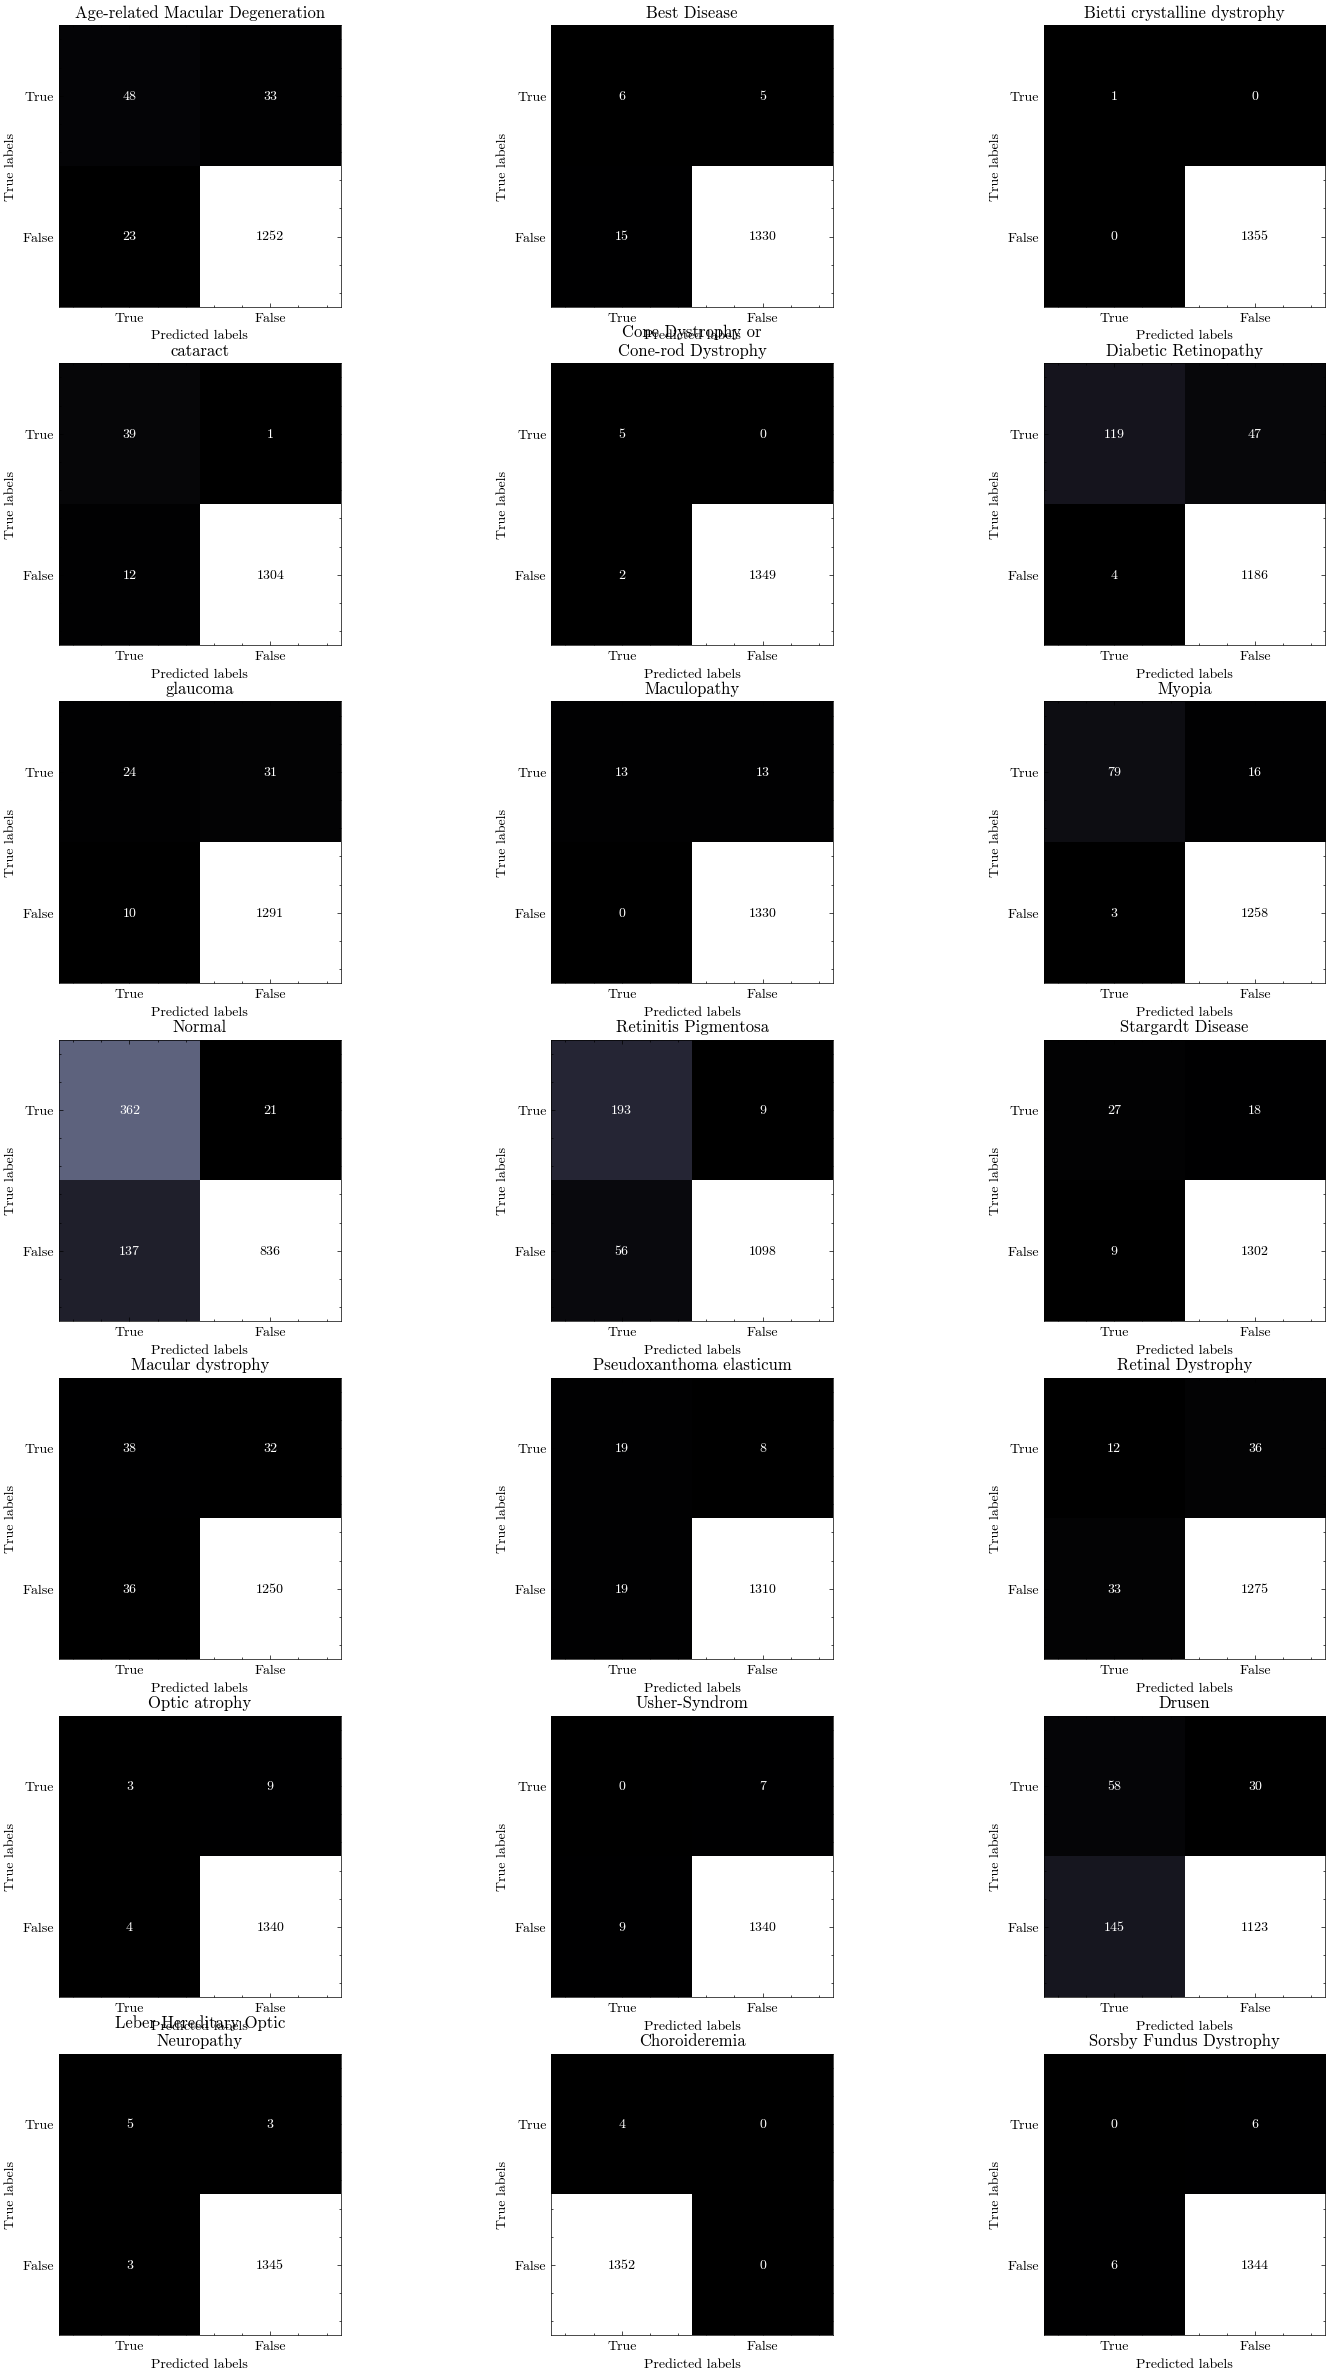

In [257]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(labels_to_encode) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
#save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices.png')

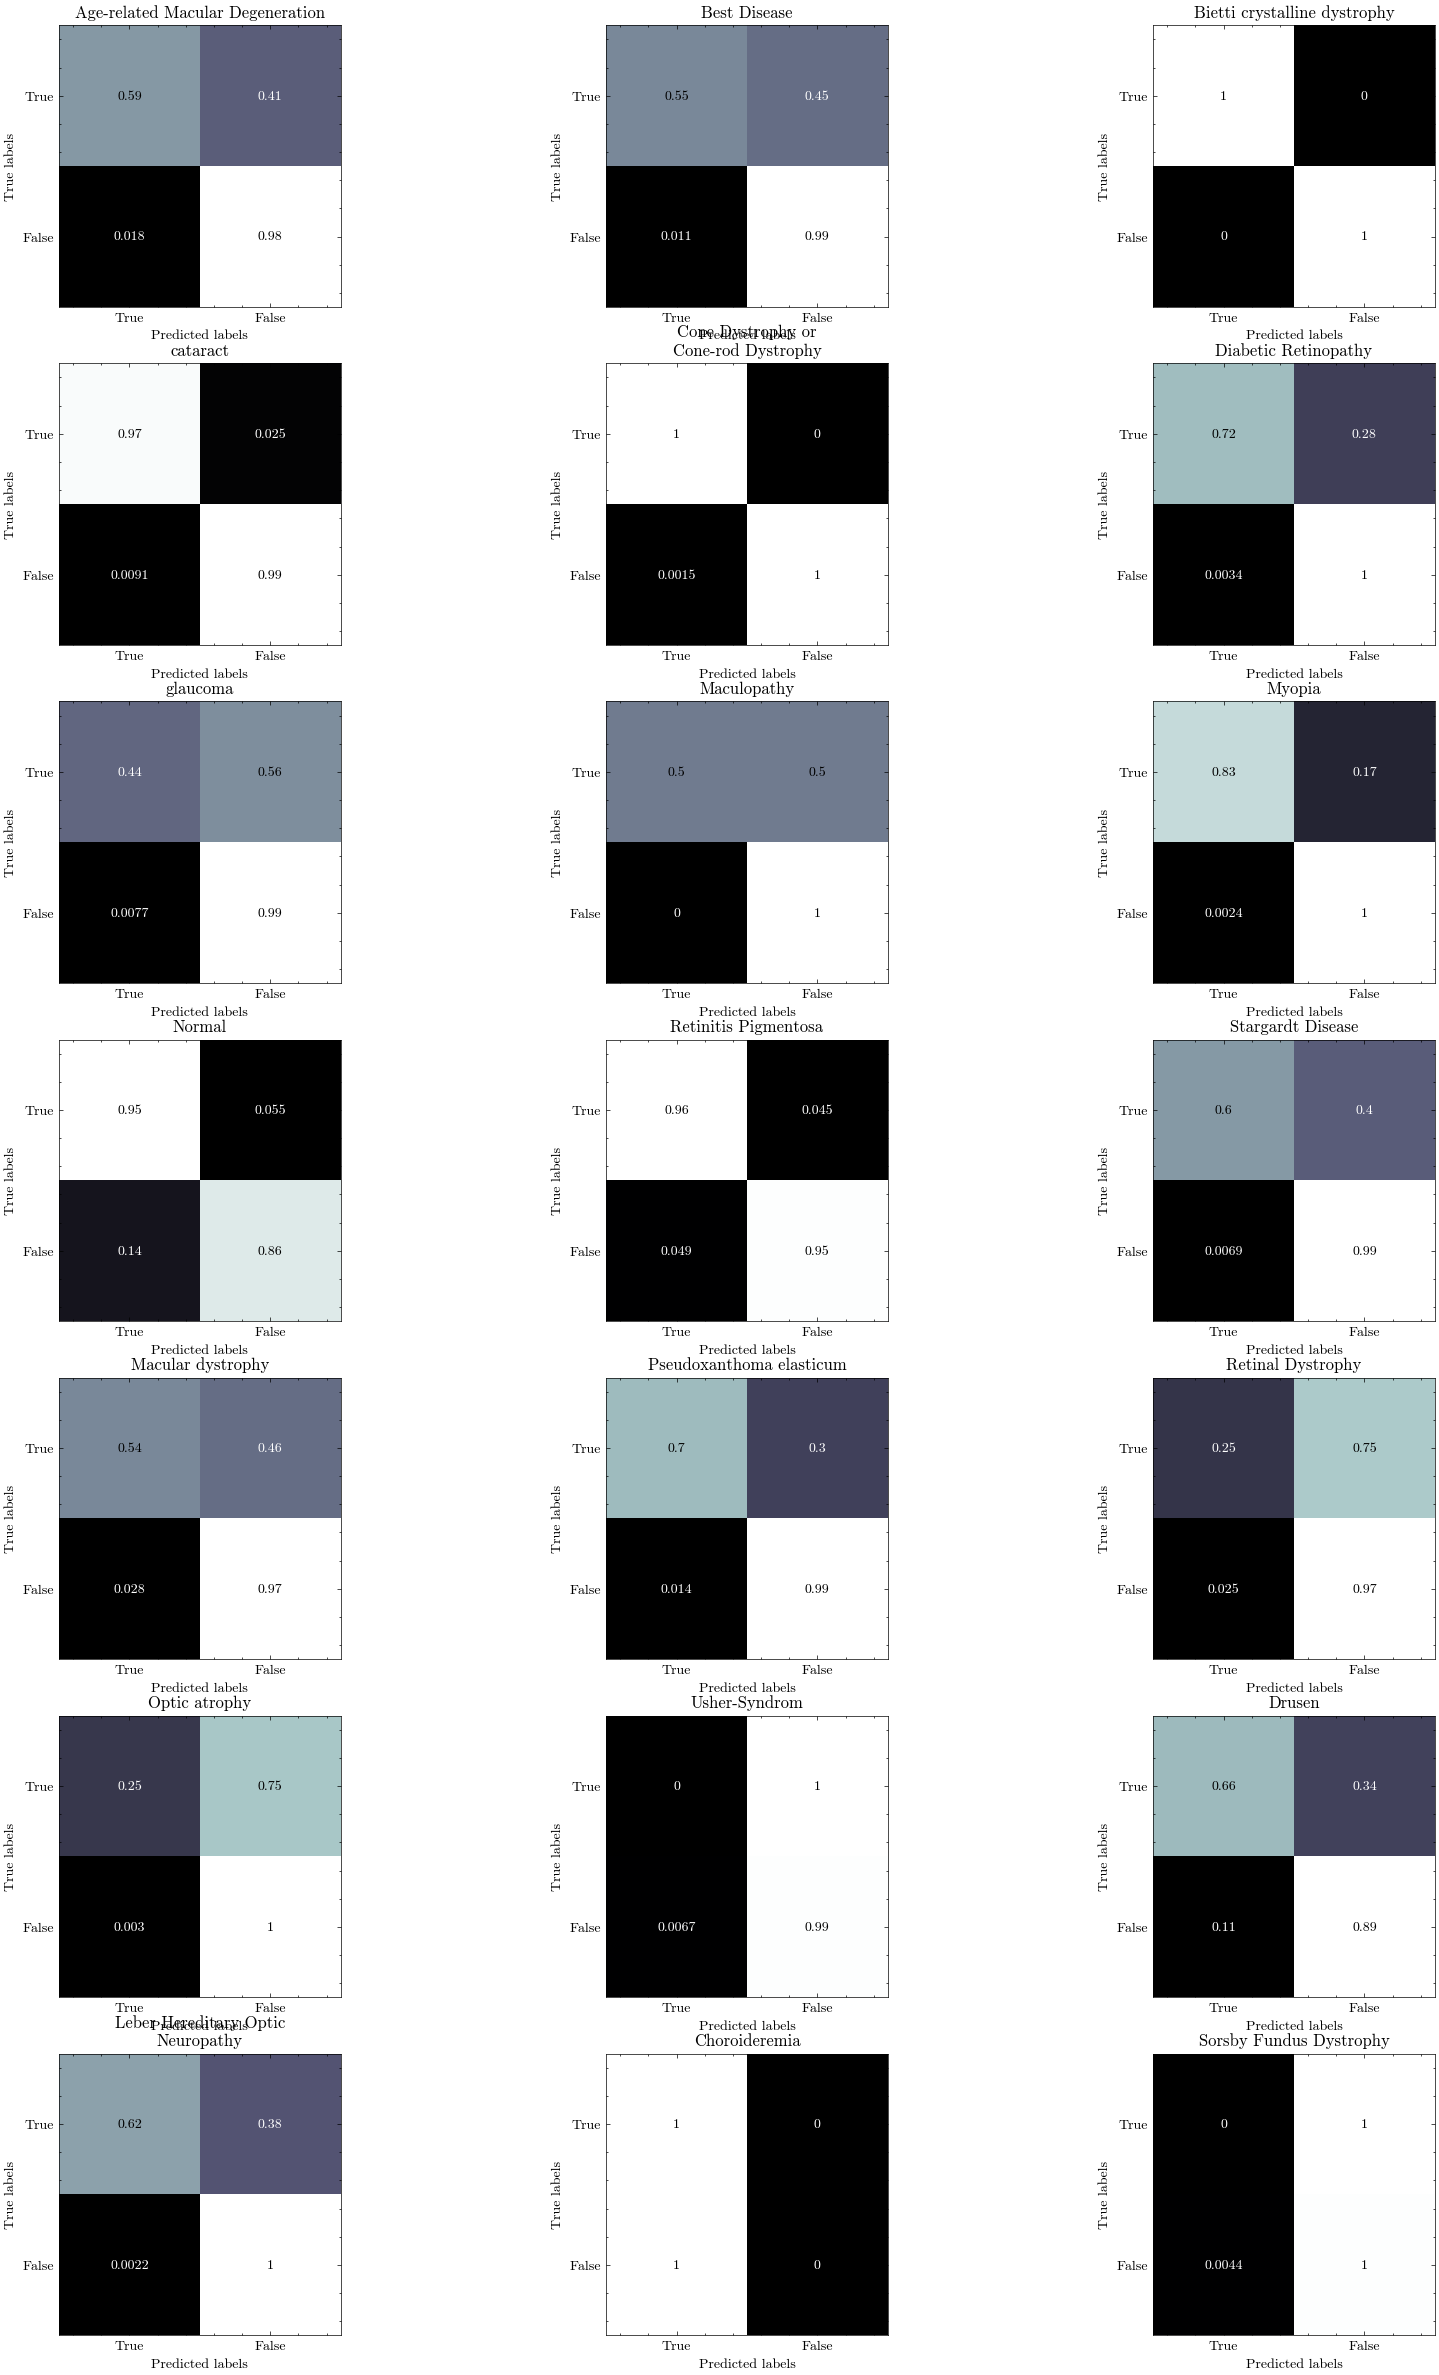

In [258]:
#plot the same confusion matrices with the row normalised values
cm_normalizer = confusion_matrices.sum(axis=2)#[:,np.newaxis]
#add a new dimension to the normalizer
cm_normalizer = cm_normalizer[:,np.newaxis]
#add a copy of the normalizer to the normalizer

#cm_normalizer = np.concatenate([cm_normalizer, cm_normalizer], axis=0)
reversed_normalizer = np.flip(cm_normalizer, axis=-1)
cm_normalizer=np.concatenate([cm_normalizer, reversed_normalizer], axis=1)
#flip the normalizer
cm_normalizer[:,:,1] = cm_normalizer[:,0,:]
normalized_cms = confusion_matrices / cm_normalizer
flipped_normalised_cms = np.flip(np.flip(normalized_cms, axis=-1), axis=-2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_normalised_cms[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    #save the figure
plt.savefig(f'{evaluations_save_folder}/confusion_matrices_normalized.png')

In [259]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
best_thresholds = np.array(best_thresholds)
#calculate the precision, recall, accuracy and f1 score
precision_macro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
recall_macro = multi_label_recall(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
accuracy_macro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
f1_macro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
#do the same for the micro scores
precision_micro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
recall_micro = multi_label_recall(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
accuracy_micro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
f1_micro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)

#save the evaluation metrics in a dictionary
evaluation_metrics = {
    'precision_macro': precision_macro,
    'recall_macro': recall_macro,
    'accuracy_macro': accuracy_macro,
    'f1_macro': f1_macro,
    'precision_micro': precision_micro,
    'recall_micro': recall_micro,
    'accuracy_micro': accuracy_micro,
    'f1_micro': f1_micro
}
#save the evaluation metrics
with open(f'{evaluations_save_folder}/evaluation_metrics.json', 'w') as f:
    json.dump(evaluation_metrics, f)

TP: 1055
FP: 1878
TN: 25218
FN: 325
-----------------------------------


In [260]:
#print the evaluation metrics
for key, value in evaluation_metrics.items():
    print(key,':', round(value,2))

precision_macro : 0.57
recall_macro : 0.63
accuracy_macro : 0.92
f1_macro : 0.6
precision_micro : 0.36
recall_micro : 0.76
accuracy_micro : 0.92
f1_micro : 0.49


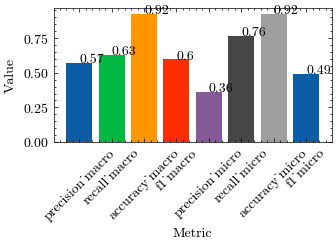

In [261]:
#plot the evaluation metrics
plt.figure()
for metric_name, metric_value in evaluation_metrics.items():
    plt.bar(metric_name, metric_value)
    plt.xticks(rotation=45)
    plt.xlabel('Metric')
    plt.ylabel('Value')
    #annotate the bar with the value
    plt.text(metric_name, metric_value, str(round(metric_value, 2)))
plt.tight_layout()
plt.savefig(f'{evaluations_save_folder}/evaluation_metrics.png')
plt.show()

In [262]:
#calculate the metrics for every test dataset
#best_thresholds = best_thresholds.cpu().numpy()
score_dict = {'data_source' : [], 'f1_micro' : [], 'f1_macro': [], 'precision_micro': [], 'precision_macro': [], 'recall_micro': [], 'recall_macro': [], 'accuracy_micro': [], 'accuracy_macro': []}
if os.path.exists(f'{evaluations_save_folder}/break_down_scores.json'):
    with open(f'{evaluations_save_folder}/break_down_scores.json', 'r') as f:
        score_dict = json.load(f)
else:
    for test_dataset, matching_package in zip(test_datasets, test_packages):
        y_true_single = []
        y_pred_single = []
        x_single = []
        model.to(device)
        model.eval()
        single_test_loader = DataLoader(test_dataset, batch_size=164, num_workers=num_workers)
        with torch.no_grad():
            for inputs, labels in single_test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                y_true_single.append(labels.detach().clone())
                y_pred_single.append(outputs.detach().clone())
                x_single.append(inputs.detach().clone())
        y_true_single = torch.cat(y_true_single, dim=0).cpu()
        y_pred_single = torch.cat(y_pred_single, dim=0).cpu()
        x_single = torch.cat(x_single, dim=0).cpu()
        y_pred_single_cm = torch.sigmoid(y_pred_single) > torch.Tensor(best_thresholds)
        #calculate precision, recall, accuracy and f1 score
        precision = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
        recall = multi_label_recall(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
        accuracy = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='macro')
        f1 = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='macro', threshold=best_thresholds)
        #and micro scores
        precision_micro = multi_label_precision(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
        recall_micro = multi_label_recall(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
        accuracy_micro = multi_label_accuracy(y_true_single, y_pred_single, threshold=best_thresholds, averaging_type='micro')
        f1_micro = multi_label_f_beta(y_true_single, y_pred_single, beta=1.0, averaging_type='micro', threshold=best_thresholds)
        #save the scores
        score_dict['data_source'].append(matching_package.data_source_name)
        score_dict['f1_micro'].append(f1_micro)
        score_dict['f1_macro'].append(f1)
        score_dict['precision_micro'].append(precision_micro)
        score_dict['precision_macro'].append(precision)
        score_dict['recall_micro'].append(recall_micro)
        score_dict['recall_macro'].append(recall)
        score_dict['accuracy_micro'].append(accuracy_micro)
        score_dict['accuracy_macro'].append(accuracy)

    #save the scores to a json file
    with open(f'{evaluations_save_folder}/break_down_scores.json', 'w') as f:
        json.dump(score_dict, f)


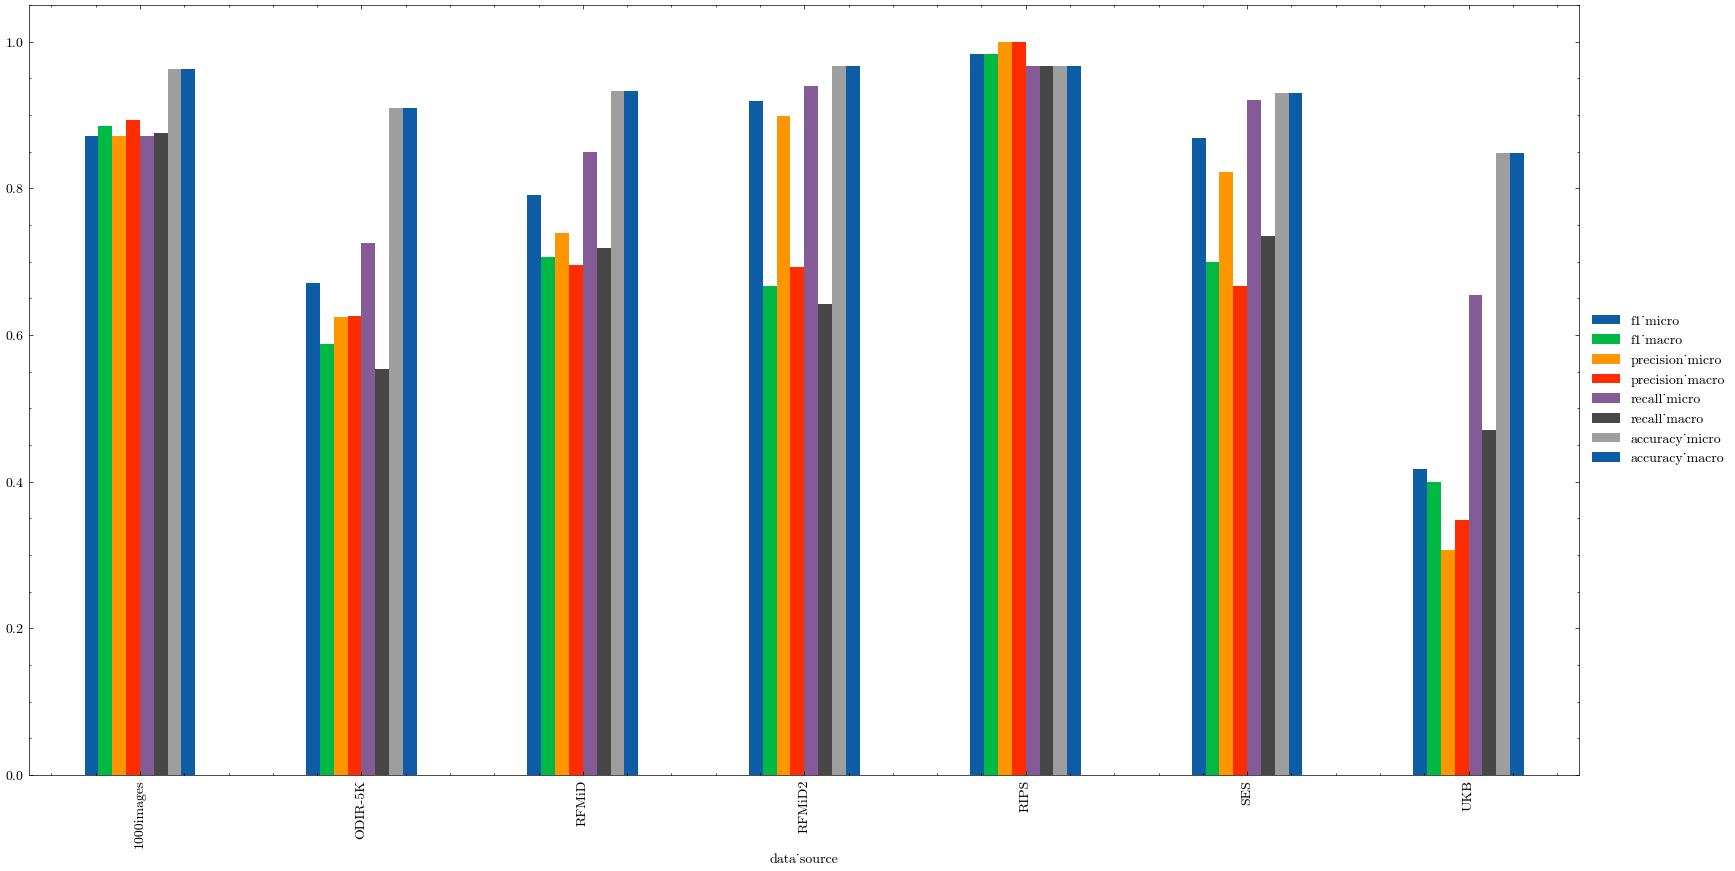

In [263]:
#create a pandas dataframe from the score dict
score_df = pd.DataFrame(score_dict)
#group the scores by data source
grouped_scores = score_df.groupby('data_source').mean()
#plot the grouped scores
grouped_scores.plot(kind='bar', figsize=(20, 10))
plt.savefig(f'{evaluations_save_folder}/grouped_scores.png')
#move the legend outside of the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [264]:
grouped_scores.round(2).head(10)

,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro,accuracy_micro,accuracy_macro
data_source,,,,,,,,
1000images,0.87,0.88,0.87,0.89,0.87,0.88,0.96,0.96
ODIR-5K,0.67,0.59,0.62,0.63,0.73,0.55,0.91,0.91
RFMiD,0.79,0.71,0.74,0.69,0.85,0.72,0.93,0.93
RFMiD2,0.92,0.67,0.90,0.69,0.94,0.64,0.97,0.97
RIPS,0.98,0.98,1.00,1.00,0.97,0.97,0.97,0.97
SES,0.87,0.70,0.82,0.67,0.92,0.73,0.93,0.93
UKB,0.42,0.40,0.31,0.35,0.65,0.47,0.85,0.85


In [265]:
score_df.head(20)

,data_source,f1_micro,f1_macro,precision_micro,precision_macro,recall_micro,recall_macro,accuracy_micro,accuracy_macro
0,ODIR-5K,0.670940,0.587348,0.624254,0.625106,0.725173,0.553891,0.908983,0.908983
1,RFMiD,0.790123,0.706135,0.739030,0.694697,0.848806,0.717956,0.933097,0.933097
2,RFMiD2,0.918519,0.666220,0.898551,0.692727,0.939394,0.641667,0.966667,0.966667
3,1000images,0.870968,0.884291,0.870968,0.893250,0.870968,0.875510,0.963134,0.963134
4,RIPS,0.983051,0.983051,1.000000,1.000000,0.966667,0.966667,0.966667,0.966667
5,SES,0.867925,0.698885,0.821429,0.666667,0.920000,0.734375,0.930000,0.930000
6,UKB,0.417492,0.399839,0.306667,0.348015,0.653747,0.469798,0.847976,0.847976


In [266]:
model.to(device)
model.train()
all_dropout_predictions = []
all_dropout_labels = []
#run the model on the test set with dropout enabled, 100 times
n_predictions = 100
prediction_progress_bar = tqdm.tqdm(range(n_predictions))
for i in prediction_progress_bar:
    y_test_dropout_predictions = []
    labels_dropout = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            y_test_dropout_predictions.append(outputs.detach().clone())
            labels_dropout.append(labels.detach().clone())
        y_test_dropout_predictions = torch.cat(y_test_dropout_predictions, dim=0).cpu()
        all_dropout_predictions.append(y_test_dropout_predictions)
        labels_dropout = torch.cat(labels_dropout, dim=0).cpu()
        all_dropout_labels.append(labels_dropout)
all_dropout_predictions = torch.stack(all_dropout_predictions, dim=0)
all_dropout_labels = torch.stack(all_dropout_labels, dim=0)

100%|██████████| 100/100 [23:50<00:00, 14.30s/it]


In [267]:
#rearrrange the predictions so that the first dimension is the number of predictions
print(all_dropout_predictions.shape)

torch.Size([100, 1356, 21])


In [268]:
import numpy as np
from scipy.stats import entropy


# variable probs with shape [batch_size, num_classes, num_ensemble_members]
def total_uncertainty_entropy(probs, norm=False):
    t_u = entropy(np.mean(probs, axis=0), axis=0, base=2)
    if norm:
        t_u = t_u / np.log2(probs.shape[1])
    return t_u


def epistemic_uncertainty_entropy(probs, norm=False):
    mean_probs = np.mean(probs, axis=0)
    mean_probs = np.repeat(np.expand_dims(mean_probs, 2), repeats=probs.shape[2], axis=2)
    e_u = entropy(probs, mean_probs, axis=0, base=2)
    if norm:
        e_u = e_u / np.log2(probs.shape[1])
    e_u = np.mean(e_u, axis=1)
    return e_u


def aleatoric_uncertainty_entropy(probs, norm=False):
    a_u = entropy(probs, axis=0, base=2)
    if norm:
        a_u = a_u / np.log2(probs.shape[1])
    a_u = np.mean(a_u, axis=1)
    return a_u

def total_uncertainty_variance(probs):
    mean = np.mean(probs, axis=0)
    t_u = np.sum(mean * (1 - mean), axis=1)
    return t_u


def aleatoric_uncertainty_variance(probs):
    a_u = np.mean(np.sum(probs * (1 - probs), axis=1), axis=1)
    return a_u


def epistemic_uncertainty_variance(probs):
    mean = np.mean(probs, axis=2, keepdims=True)
    e_u = np.mean(np.sum(probs * (probs - mean), axis=1), axis=1)
    return e_u

In [269]:
import numpy as np
from scipy.stats import entropy

# variable probs with shape [num_ensemble_members, batch_size, num_classes]
def total_uncertainty_entropy(probs, norm=False):
    t_u = entropy(np.mean(probs, axis=0), axis=1, base=2)  # Change axis to 1
    if norm:
        t_u = t_u / np.log2(probs.shape[2])
    return t_u

def epistemic_uncertainty_entropy(probs, norm=False):
    mean_probs = np.mean(probs, axis=0)
    mean_probs = np.repeat(np.expand_dims(mean_probs, 0), repeats=probs.shape[0], axis=0)
    e_u = entropy(probs, mean_probs, axis=2, base=2)  # Change axis to 2
    if norm:
        e_u = e_u / np.log2(probs.shape[2])
    e_u = np.mean(e_u, axis=0)  # Change axis to 0
    return e_u

def aleatoric_uncertainty_entropy(probs, norm=False):
    a_u = entropy(probs, axis=2, base=2)  # Change axis to 2
    if norm:
        a_u = a_u / np.log2(probs.shape[2])
    a_u = np.mean(a_u, axis=0)  # Change axis to 0
    return a_u

def total_uncertainty_variance(probs):
    mean = np.mean(probs, axis=0)
    t_u = np.sum(mean * (1 - mean), axis=1)  # Change axis to 1
    return t_u

def aleatoric_uncertainty_variance(probs):
    a_u = np.mean(np.sum(probs * (1 - probs), axis=2), axis=0)  # Change axis to 2, then to 0
    return a_u

def epistemic_uncertainty_variance(probs):
    mean = np.mean(probs, axis=0, keepdims=True)
    e_u = np.mean(np.sum(probs * (probs - mean), axis=2), axis=0)  # Change axis to 2, then to 0
    return e_u


In [270]:
#calculate the entopy uncertainty, aleatoric and epistemic uncertainty
all_dropout_predictions_probs = torch.sigmoid(all_dropout_predictions)
all_dropout_predictions_numpy = all_dropout_predictions_probs.numpy()
entropy_uncertainty = total_uncertainty_entropy(all_dropout_predictions_numpy)
aleatoric_uncertainty = aleatoric_uncertainty_entropy(all_dropout_predictions_numpy)
epistemic_uncertainty = epistemic_uncertainty_entropy(all_dropout_predictions_numpy)
#total uncertainty entropy
total_uncertainity_entropy = total_uncertainty_entropy(all_dropout_predictions_numpy)


In [271]:
import scienceplots
plt.style.use(['science', 'no-latex'])

In [272]:
def plot_f1_rejection_curve(pred, labels, uncertainties):
    #predictions = np.argmax(probs, axis=1)
    labels = np.array(labels).astype(int).squeeze()
    data = np.vstack([pred, labels, uncertainties]).T
    data = data[data[:,2].argsort()]
    f1__macro_scores = []
    f1_micro_scores = []
    rejection_rates = []
    for i in range(len(data),1,-1):
        retained_data = data[:i]
        f1_macro = multi_label_f_beta(retained_data[:,1], retained_data[:,0], beta=1.0, averaging_type='macro', threshold=best_thresholds)
        f1_micro = multi_label_f_beta(retained_data[:,1], retained_data[:,0], beta=1.0, averaging_type='micro', threshold=best_thresholds)
        f1__macro_scores.append(f1_macro)
        f1_micro_scores.append(f1_micro)
        rejection_rates.append(1 - i/len(data))
    plt.figure(figsize=(10, 6))
    plt.plot(rejection_rates, f1__macro_scores, label='f1 macro score')
    plt.plot(rejection_rates, f1_micro_scores, label='f1 micro score')
    plt.title('F1 Score Rejection Curve')
    plt.xlabel('Rejection Rate')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.ylabel(f'f1 score')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.savefig(f'{evaluations_save_folder}/f1_rejection_curve.png')
    plt.show()

In [273]:
import numpy as np
import matplotlib.pyplot as plt

def plot_f1_rejection_curve(pred, labels, uncertainties, multi_label_f_beta = multi_label_f_beta, best_thresholds = best_thresholds, evaluations_save_folder = evaluations_save_folder, uncertainity_type = None):
    # Ensure inputs are numpy arrays
    uncertainties = np.array(uncertainties)

    #mean the predictions
    pred = torch.mean(pred, axis=0)
    labels = torch.mean(labels, axis=0)
    if pred.shape[0] != labels.shape[0] or pred.shape[0] != uncertainties.shape[0]:
        raise ValueError("The dimensions of pred, labels, and uncertainties must match after processing.")
    
    # # Reshape predictions and labels
    # pred_flat = pred.reshape(num_samples, -1)
    # labels_flat = labels.reshape(num_samples, -1)
    
    # # Combine predictions, labels, and uncertainties
    # data = np.hstack((pred_flat, labels_flat, uncertainties[:, np.newaxis]))

    # # Sort data by uncertainties
    # data = data[data[:, -1].argsort()]

    #get the sorted indices
    sorted_indices = np.argsort(uncertainties)
    pred = pred[sorted_indices]
    labels = labels[sorted_indices]
    f1_macro_scores = []
    f1_micro_scores = []
    rejection_rates = []

    for i in range(len(pred), 1, -1):
        retained_pred = pred[:i, :]
        retained_labels = labels[:i, :]
        
        
        f1_macro = multi_label_f_beta(retained_labels, retained_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
        f1_micro = multi_label_f_beta(retained_labels, retained_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)
        
        f1_macro_scores.append(f1_macro)
        f1_micro_scores.append(f1_micro)
        rejection_rates.append(1 - i / len(pred))

    plt.figure(figsize=(10, 6))
    plt.plot(rejection_rates, f1_macro_scores, label='F1 Macro Score')
    plt.plot(rejection_rates, f1_micro_scores, label='F1 Micro Score')
    plt.title('F1 Score Rejection Curve')
    plt.xlabel('Rejection Rate')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.savefig(f'{evaluations_save_folder}/f1_rejection_curve_{uncertainity_type}.png')
    plt.show()


In [277]:
print(aleatoric_uncertainty)

[2.2238402  1.3671021  0.1097732  ... 1.5379769  0.46103114 0.9444048 ]


In [274]:
#print shape of the predictions and labels
print(all_dropout_predictions.shape)
print(all_dropout_labels.shape)
print(entropy_uncertainty.shape)

torch.Size([100, 1356, 21])
torch.Size([100, 1356, 21])
(1356,)


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positiv

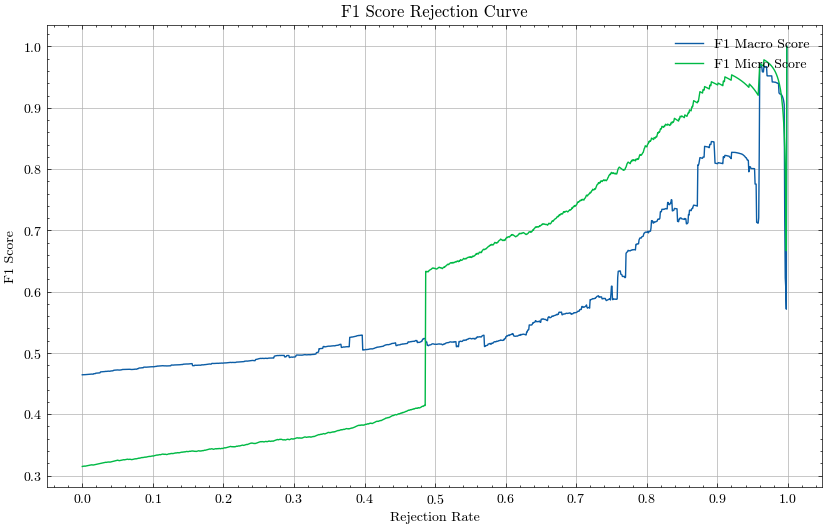

In [275]:
#create a rejection curve for the aleatoric uncertainty
all_dropout_labels_numpy = all_dropout_labels.numpy()
plot_f1_rejection_curve(all_dropout_predictions, all_dropout_labels, aleatoric_uncertainty, uncertainity_type='aleatoric')


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:149: RuntimeWarning: invalid value encountered in divide
  precision = true_positiv

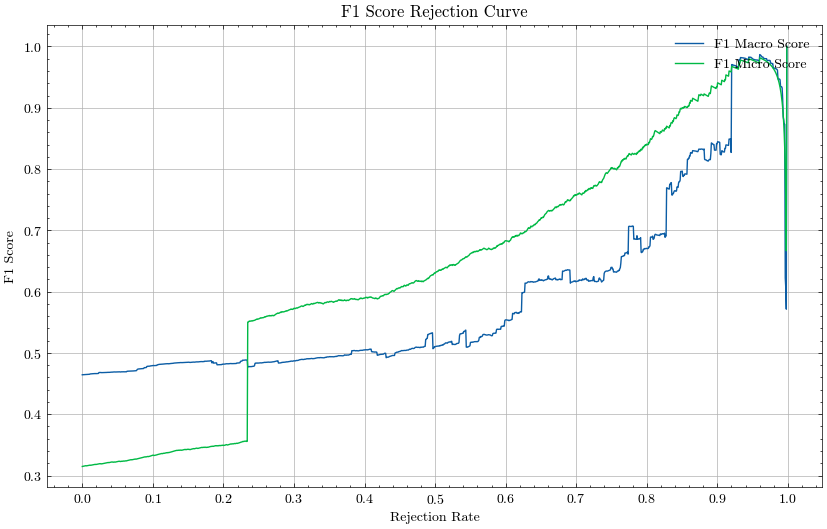

In [276]:
plot_f1_rejection_curve(all_dropout_predictions, all_dropout_labels, epistemic_uncertainty, uncertainity_type='epistemic')